In [20]:
import numpy             as np
import numpy.random      as ra
import numpy.matlib      as mlib
import matplotlib.pyplot as plt
import scipy.fftpack     as spfft # For the Fourier transform
import pywt                       # Wavelet transform software 

from matplotlib.image     import imread
from skimage.util         import random_noise
from scipy                import signal
from IPython.display      import display, Math, Latex

plt.rcParams['figure.figsize'] = (10, 7)

In [21]:
from helper import *

## ***Before you start***

#### Please make sure you have installed the libraries listed in the header and have got the data and the helper.py script.

# Sparsity, denoising and compressed sensing

During the lectures, we discussed the role of the $\ell_1$ and $\ell_2$ norm in computing solutions to an underdetermined system of equations. We also described how sparsity and incoherent random sampling play a crucial role in compressive sensing reconstruction. In this practical, we will explore these concepts in more detail. 

This practical consists of two parts. Part A deals with signal denoising and sparsity, and part B with compressed sensing reconstruction of an MRI image.

I hope you enjoy it!



## A. Sparse signal denoising:

In this section, we are going to explore denoising of a $1$D sparse signal containing random noise. We will attempt this by using:


- $\ell_2$  regularization: 
 
   $\hat{x} = \underset{x}{\operatorname{argmin}} \frac{1}{2}\| \hat{x}-y \| _2^2 + \lambda\frac{1}{2}\|\hat{x}\|_2$

   where $\|x\|_2 = \sqrt{\sum x_i^2}$
   

-   $\ell_1$ regularization:
   
     $\hat{x} = \underset{x}{\operatorname{argmin}} \frac{1}{2}\| \hat{x}-y \| _2^2 + \lambda\frac{1}{2}\|\hat{x}\|_1$

    where $\|x\| = \sum |x_i|$



**a)** First, let's start by generating a sparse-noisy signal $y$ and plotting the denoised reconstruction $\hat{x}$:
1. Generate a "signal" $y = x + n$, of length $100$ and with $7$ non-zero coefficients. Here, n is random Gaussian noise with std, $\sigma = 0.05$
   
2. The closed form solution for the $\ell_2$ minimization problem is given by:
$$\hat x = \frac{1}{1+\lambda} y $$

plot this solution for $\lambda = [0.01,0.05,0.1,0.5]$

   
Question: Is $\hat{x}$ sparse?


In [3]:
# Generate a length-100 vector, x, with 7 randomly distributed non-zero coeﬃcients
L   = 100                                 # Lenght vector
nzc = [0,2, 0.3, 0.4, 0.5, 0.6, 0.8, 1]    # Choose 7 non-zero coefficients between [0,1]
x   = np.array( nzc +[0] *(L- len(nzc) ))  # create an array with zeros everywhere but at the 7 selected locations
x   = x[ np.random.permutation(L) -1 ]     # Shuffle the vector components

# Generate your "measurements" y by adding random Gaussian noise with standard deviation $\sigma$
sigma = 0.05
y     = x + sigma*np.random.randn(L)

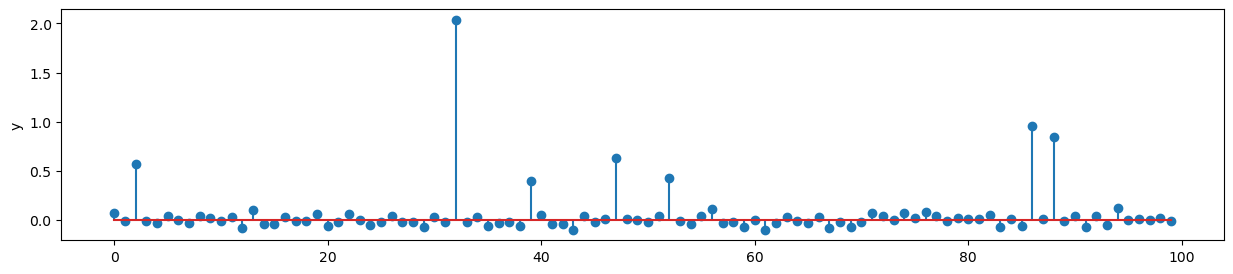

In [4]:
plt.figure( figsize = (15,3))
plt.stem(y)
plt.ylabel("y")
plt.show()

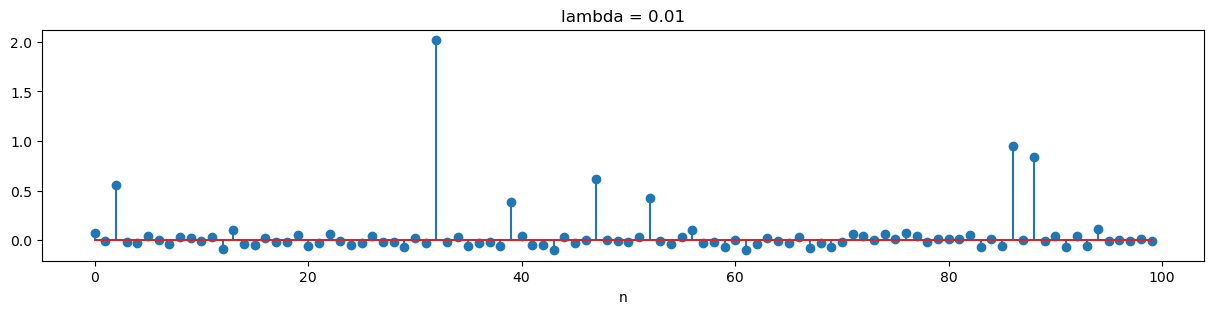

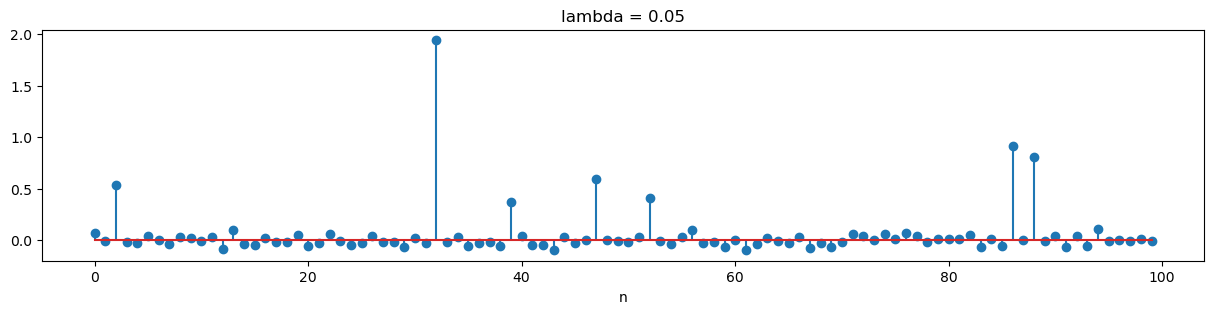

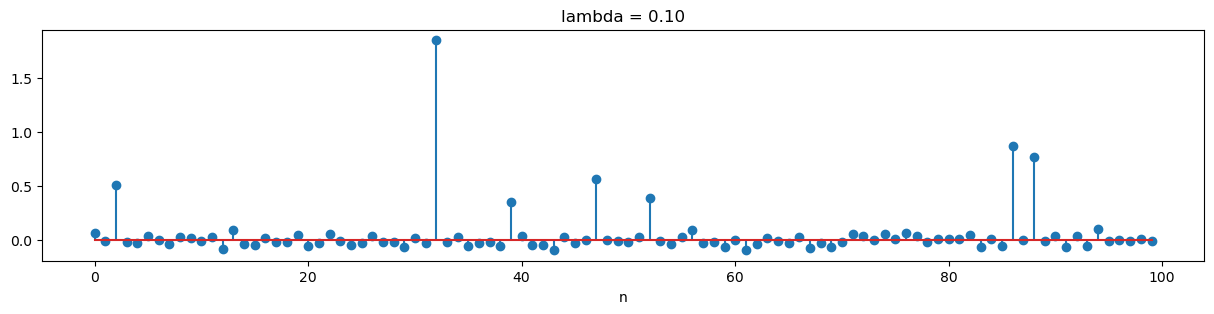

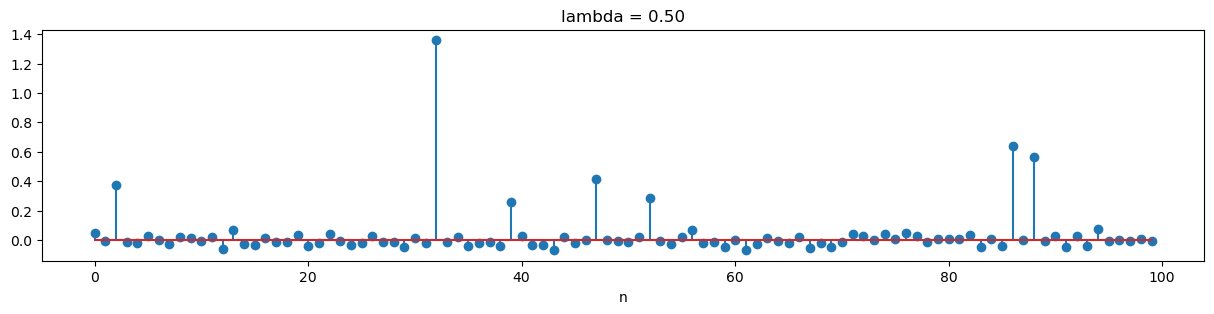

In [22]:
# Plot the $\ell_2$ solution (xhat) for differet lambdas
Lambda = [0.01,0.05,0.1,0.5]
for lamb in Lambda:
    xhat = 1 /(1 +lamb) *y
    plt.figure( figsize = (15,3))
    plt.stem( xhat )
    plt.title( 'lambda = %.2f' %lamb)
    plt.xlabel('n')

**b)** Instead of the $\ell_2$ regularization, we are going to use the $\ell_1$. It turns out that since the variables $\hat{x}_i$ are independent, we can minimise the problem for each of them independently, that is $\arg \min \frac{1}{2}\| \hat{x}_i-y_i \| _2^2 + \lambda\frac{1}{2}\|\hat{x}_i\|_1$. The solution, has a closed form, given by:

- If $y_i<-\lambda \rightarrow  \hat{x}_i = y_i +\lambda$  
  
- If $|y_i|< \lambda\rightarrow \hat{x}_i = 0$   
  
- If $y_i>\lambda \rightarrow \hat{x}_i = y_i -\lambda$  

These conditions define the so-called `soft-thresholding` function.

Write the \emph{soft-thresholding} function that takes as arguments $y$ and $\lambda$ and returns $\hat{x}$ in the interval $[-15,15]$ with $\lambda = 2$

What happens when $y< \lambda$ and when $y> \lambda$?

Apply your `soft-thresholding` function to the noisy signal $y$ for $λ = [0.01,0.05,0.1,0.2]$.

Is the solution sparse?

What does happen if you keep increasing $\lambda$?

In [6]:
# Construct the soft-thresholding function
def STH(y, L): 
    #SoftThresh -- Apply Soft Threshold to y
    res = (abs(y) -L)
    res = (res +abs(res)) /2.
    xh  = np.sign(y) *res
    return xh

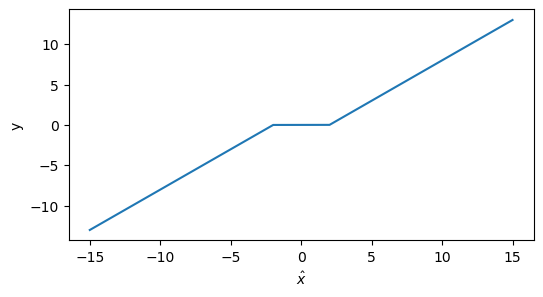

In [25]:
# Plot the output for t in [-15, 15] and lambda = 2
b    = 15
yt   = np.r_[-b:b:0.01]
lbd  = 2

plt.figure( figsize = (6,3))
plt.plot(yt, STH(yt, lbd))
plt.ylabel("y")
plt.xlabel(r"$\hat{x}$")
plt.show()

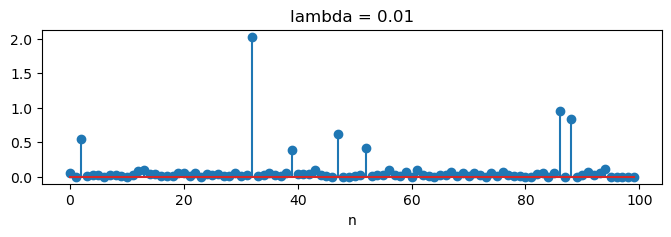

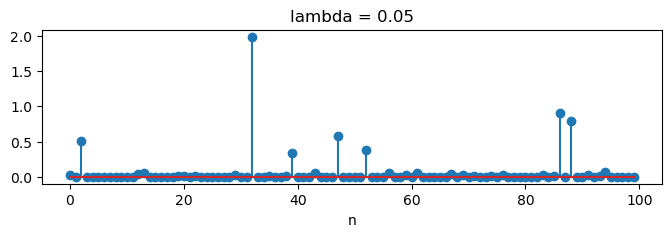

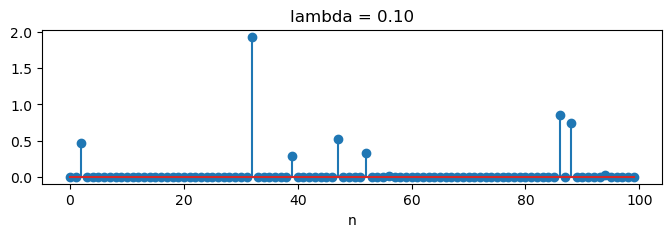

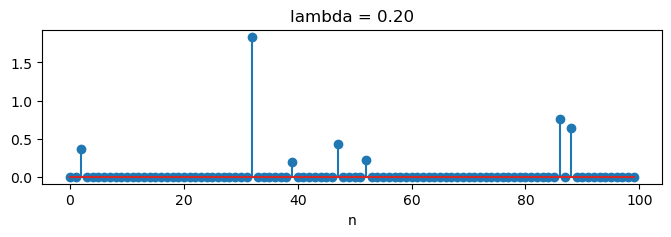

In [26]:
Lambda = [0.01,0.05,0.1,0.2]
for lamb in Lambda:
    xhat = STH(y, lamb)
    plt.figure( figsize = (8,2))
    plt.stem( abs(xhat) )
    plt.title( 'lambda = %.2f' %lamb)
    plt.xlabel('n')

## B. 2D compressed sensing reconstruction of MRI Data

In this seciton we are going to work with [brain data](https://inst.eecs.berkeley.edu/~ee123/sp16/hw/brain.npz) data provided [Prof. Michael Lustig](https://people.eecs.berkeley.edu/~mlustig/). 

Note: In the helper.py file provided, you can find the functions we need to visualise wavelet transforms.

#### a) Non-uniform random sampling

The energy in many natural images is concentrated in lower spatial frequencies; thus, more samples should be allocated there. 
The provided brain data contain two $3$-fold undersampling masks, measuring similar number of samples, and their corresponding probability density functions (PDF):

-  Uniform mask: `mask_unif`  and `pdf_unif`
-  Variable desnity mask: `mask_vardens` and `pdf_vardens`

For each mask:

1. Compute the 2D Fourier transform of the image using a centred 2D FFT. 

2. Multiply by the uniform mask, divide by the appropriate PDF (called density compensation), and compute the zero-filled Fourier transform    
3. Display the image and the difference image compared to the original image.

Which gives you a better reconstruction?

In [9]:
# load brain data
data = np.load('brain.npz')

In [10]:
# Extract the brain data and store it in the corresponding variables
im, mask_unif, mask_vardens, pdf_unif, pdf_vardens = \
data['im'], data['mask_unif'], data['mask_vardens'], data['pdf_unif'], data['pdf_vardens'], 

In [11]:
def fft2c(x):
    return 1 / np.sqrt(np.prod(x.shape)) * np.fft.fftshift(np.fft.fft2(np.fft.ifftshift(x)))

def ifft2c(y):
    return np.sqrt(np.prod(y.shape)) * np.fft.ifftshift(np.fft.ifft2(np.fft.fftshift(y)))

In [12]:
M  = fft2c (im)
Mu  = M * mask_unif / pdf_unif
imu = ifft2c (Mu)

Mv  = M * mask_vardens / pdf_vardens
imv = ifft2c(Mv)

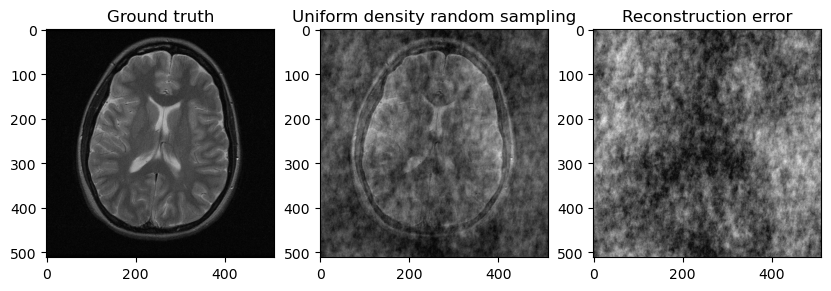

In [13]:
plt.figure()
plt.subplot (1,3,1)
imshowgray (abs (im) )
plt.title("Ground truth")
#
plt.subplot (1,3,2)
imshowgray (abs (imu) )
plt.title("Uniform density random sampling")
#
plt.subplot (1,3,3)
imshowgray (abs (im-imu) )
plt.title("Reconstruction error")
plt. show()

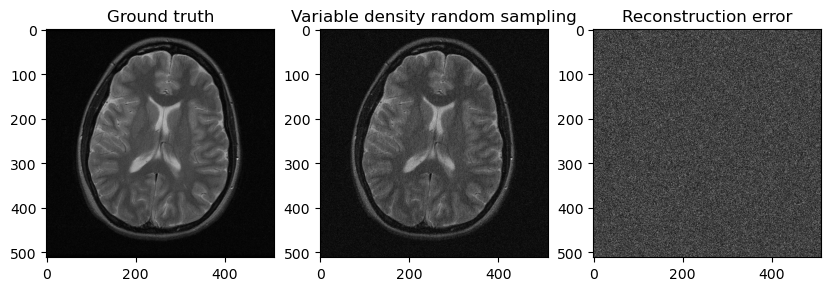

In [14]:
plt.figure()
plt.subplot (1,3,1)
imshowgray (abs (im) )
plt.title("Ground truth")
#
plt.subplot (1,3,2)
imshowgray (abs (imv) )
plt.title("Variable density random sampling")
#
plt.subplot (1,3,3)
imshowgray (abs (im-imv) )
plt.title("Reconstruction error")
plt. show()

Both sampling masks distribute the aliasing energy throughout the image, but the "noise" from the variable density mask appears much more like white noise. This indicates that the incoherence is higher for the varaible density sampling pattern than it is for the unform density sampling.

### b) Reconstruction sampling the k-space randomly

In this exercise, we are going to reconstruct the image we have obtained by sampling the k-sapace using the variable density mask. To that end:

    1. Implement a Projection Over Convex Sets (POCS) type algorithm by filling the skeleton provided--this is an simple POCS type example. 
    
    2. Get an idea of reasonable values for lambda by examining what would be thresholded in the wavelet decomposition.
    
    3. Reconstruct your image and plot the reconstruction error.

In [15]:
# Build a 2d POCS type altorithim

In [16]:
def POCS2D(Y, lam, nitr, ref=None):
    """Projection Over Convex Sets (POCS)"""
    err = np.zeros ( (nitr,))
    Xi  = Y.copy()
    for i in range(nitr):
    # Enforce sparsity by decomposing in Fourier and Wavelets
        xi  = ifft2c(Xi)    #  Compute the 2D inverse Fourier transform to get an estimate of the signal      
        xdw = dwt2(xi)      #  Compute the 2D WT transform of the estimated signal   
        ctxdw = ComplexSoftThresh(xdw, lam) # Threshold (complex domain)
        xi    =  idwt2 ( ctxdw )            # compute the invers of the 2D WT      
        xi = fft2c(xi)
        # Enforce data consistency by filling in missed k-space points 
        Xi = xi*(Y==0) + Y
        err[i] = np.linalg.norm(Xi - ref)
        if ref is not None:
         print( 'It %d: %0.2f' % (i, err[i]))
    return ifft2c(Xi), err

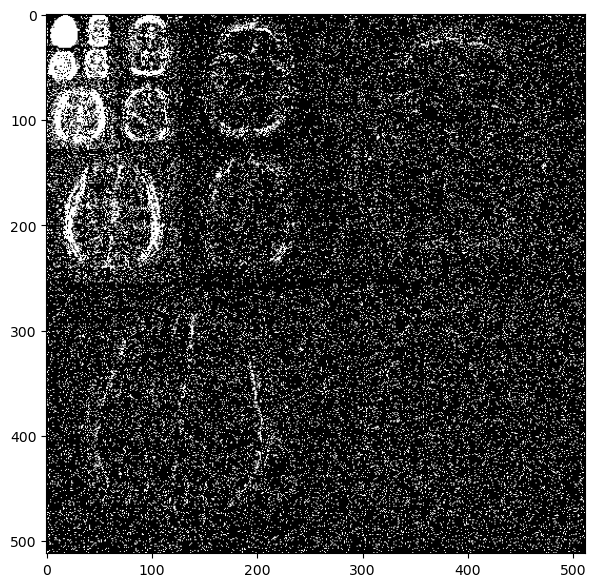

In [30]:
#  You want a significant number of coefficients to be below λ, but not all of them
#  Check the effect of lambda on the different wavelet scales start by lower values of lambda~ 0.01 and increase them

lamb = 0.1 # Choose a lambda

Wimv = dwt2(imv) # get the wavelet decomposition for the "variable density" reconstructed image.
imshowgray(abs(Wimv) > lamb) # Check what you have left out

In [31]:
Mv    = M * mask_vardens # Mask data with variable density mask (not normalised)

# Call reconstruction algorithm
nitr       = 10 # Run for at least 10-100 iterations
lam        =.1 # selected lambda
recon, err = POCS2D(Mv, lam, nitr, M)

It 0: 16.84
It 1: 16.57
It 2: 16.49
It 3: 16.45
It 4: 16.44
It 5: 16.44
It 6: 16.43
It 7: 16.43
It 8: 16.43
It 9: 16.43


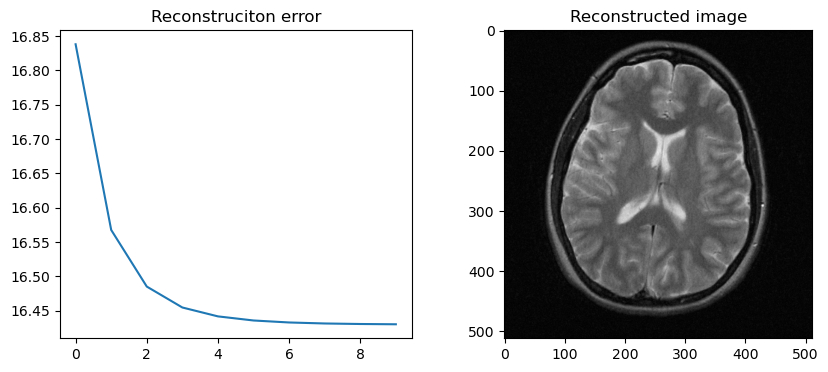

In [32]:
plt.figure( figsize = (10,4))
plt.subplot (1,2,1)
plt. plot (range (nitr), err)
plt.title("Reconstruciton error")
#
plt.subplot (1,2,2)
imshowgray (abs (recon) )
plt.title("Reconstructed image")
plt.show()